In [12]:
import xscen as xs
import xarray as xr
import cartopy.crs as ccrs
from xscen.config import CONFIG
import figanos.matplotlib as fg
import matplotlib.pyplot as plt
fg.utils.set_mpl_style('ouranos')

# Load configuration
xs.load_config(
    "../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True
)

2025-06-19 13:33:03 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-06-19 13:33:03 INFO     xscen.config    Updated the config with ../config_obs.yml.


In [13]:
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat_df = pcat.df

In [88]:
def gen_title(rec_ds, obs_ds, horizon):
    rec_inst = rec_ds.attrs["cat:institution"]
    rec_source = rec_ds.attrs["cat:source"]
    obs_inst = obs_ds.attrs["cat:institution"]
    obs_source = obs_ds.attrs["cat:source"]
    
    return f"{obs_inst}'s {obs_source} vs {rec_inst}'s {rec_source}\nHorizon: {horizon}"

from matplotlib import colors

def plot_climatology_maps():
    pcat_df_clim = pcat_df[pcat_df["processing_level"] == "climatology"]
    variable_groups = pcat_df_clim["variable"].unique()

    variables = set(item for group in variable_groups for item in group)
    mean_variables = sorted(v for v in variables if "std" not in v)

    for mean_var in mean_variables:
        print(f"Processing variable: {mean_var}")

        dt_obs = pcat.search(
            processing_level="climatology", variable=mean_var, source="AHCCD"
        ).to_dataset()

        dts_rec = pcat.search(
            processing_level="climatology", variable=mean_var, type="reconstruction"
        ).to_dataset_dict()

        for rec_id, dt_rec in dts_rec.items():
            common_horizons = set(dt_rec.horizon.values).intersection(dt_obs.horizon.values)
            if not common_horizons:
                print(f"Skipping {mean_var}: no matching horizons.")
                continue

            for horizon in common_horizons:
                rec_var = dt_rec[mean_var].sel(horizon=horizon)
                obs_var = dt_obs[mean_var].sel(horizon=horizon)

                vmin = min(rec_var.min().compute().item(), obs_var.min().compute().item())
                vmax = max(rec_var.max().compute().item(), obs_var.max().compute().item())

                norm = colors.Normalize(vmin=vmin, vmax=vmax)

                if "season" in rec_var.coords:
                    
                    # Plot gridmap
                    grid = fg.gridmap(
                        rec_var,
                        projection=ccrs.LambertConformal(),
                        fig_kw={"figsize": (20, 5), "constrained_layout": True},
                        plot_kw={
                            "col": "season",
                            "norm": norm,
                            "add_colorbar": True
                        },
                        features=["coastline"],
                        use_attrs={"suptitle": f"{rec_id} - {mean_var} - Horizon: {horizon}"},
                        enumerate_subplots=True
                    )

                    # Now overlay the scattermaps manually
                    for i, season in enumerate(rec_var.season.values):
                        ax = grid.axs.flat[i]

                        # Overlay obs scatter
                        fg.scattermap(
                            obs_var.sel(season=season),
                            ax=ax,
                            transform=ccrs.PlateCarree(),
                            plot_kw={
                                "x": "lon",
                                "y": "lat",
                                "norm": norm,
                                "add_colorbar": False,
                                "edgecolor": "grey"
                            },
                            show_time=False,
                            use_attrs={}
                        )
                        ax.set_title(str(season), fontsize=12)
                    grid.fig.suptitle(gen_title(dt_rec, dt_obs, horizon), fontsize=14)

                else:
                    
                    ax = fg.gridmap(
                        rec_var,
                        projection=ccrs.LambertConformal(),
                        plot_kw={
                            "add_colorbar": False,
                            "norm": norm
                        },
                        features=["coastline"]
                    )

                    fg.scattermap(
                        obs_var,
                        ax=ax,
                        transform=ccrs.PlateCarree(),
                        plot_kw={
                            "norm": norm,
                            "edgecolor": "grey"
                        }
                    )
                    ax.set_title(gen_title(dt_rec, dt_obs, horizon), fontsize=14)


Processing variable: pr_mean_annual_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 32 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 32 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 32 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 32 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 32 nan values were dropped when plotting the color values


Processing variable: pr_mean_seasonal_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:669: UserWarning: Only figsize and figure.add_subplot() arguments can be passed to fig_kw when using facetgrid.
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "GovCan_RDRS_NAM_reconstruction.Quebec.climatology.QS-DEC - pr_mean_seasonal_clim_mean - Horizon: 1981-2010" not found.
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 32 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 31 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 36 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-pack

Processing variable: tg_mean_annual_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "USask_EMDNA_OI_NAM_reconstruction.Quebec.climatology.QS-DEC - pr_mean_seasonal_clim_mean - Horizon: 1981-2010" not found.
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 32 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 31 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 36 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 33 nan values were dropped when plotting the color values


/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 38 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 52 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 38 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 38 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 38 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 52 nan values were dropped when plotting the color value

Processing variable: tg_mean_seasonal_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 38 nan values were dropped when plotting the color values


/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:669: UserWarning: Only figsize and figure.add_subplot() arguments can be passed to fig_kw when using facetgrid.
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "USask_EMDNA_OI_NAM_reconstruction.Quebec.climatology.QS-DEC - tg_mean_seasonal_clim_mean - Horizon: 1981-2010" not found.
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 41 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 37 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 46 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-p

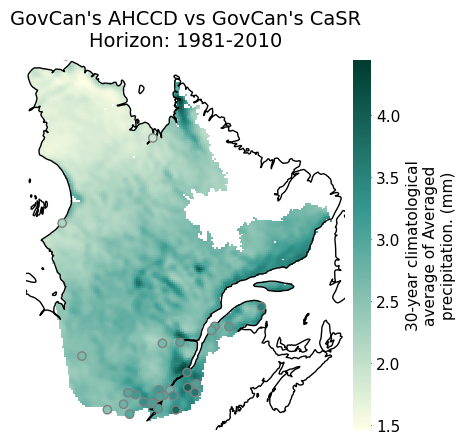

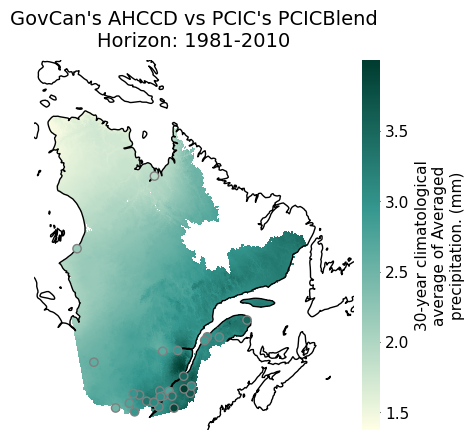

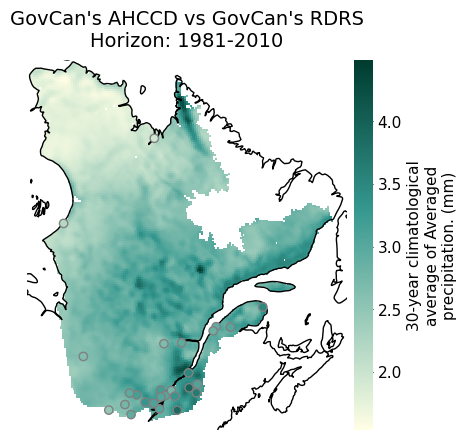

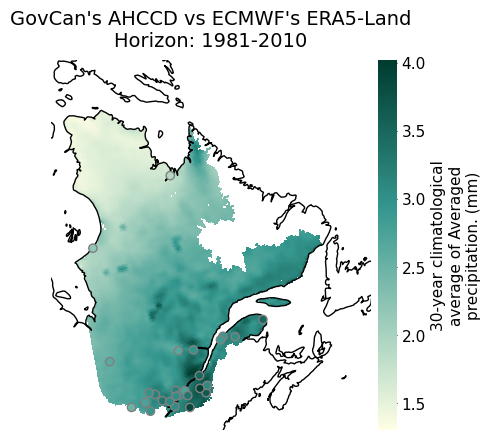

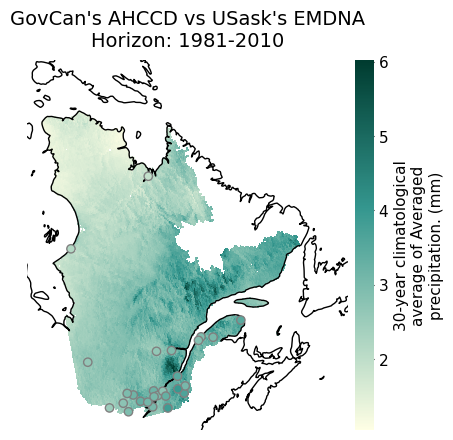

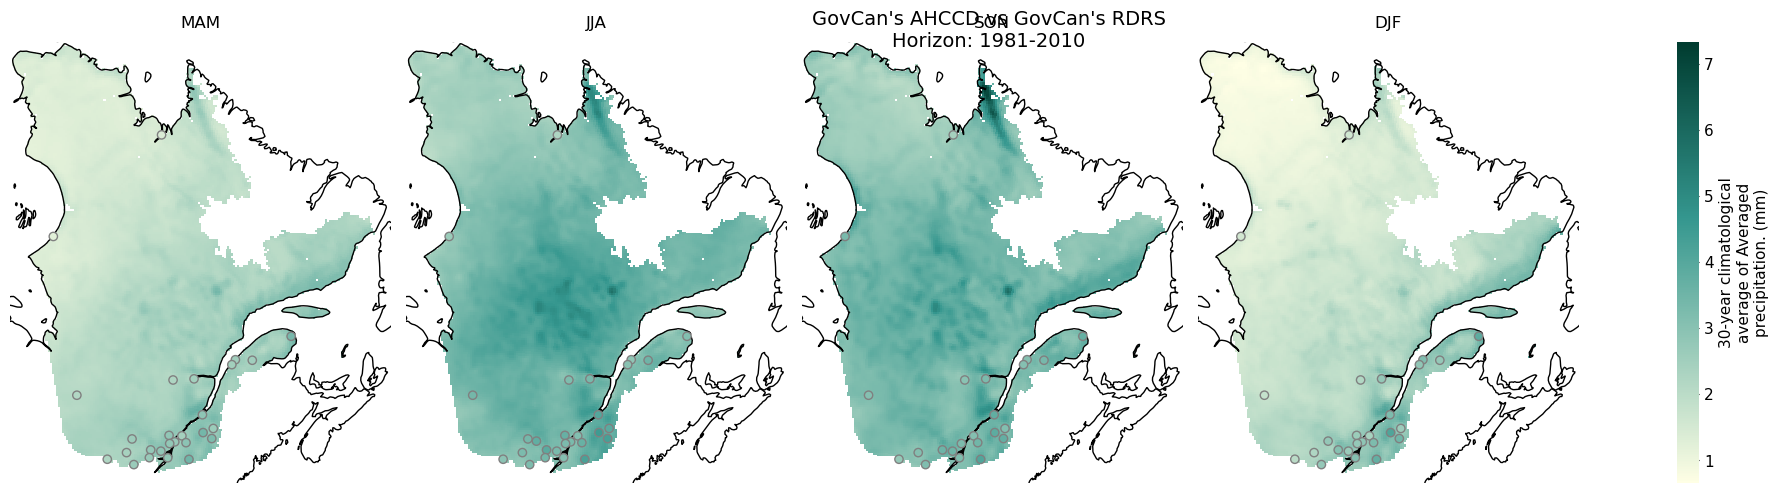

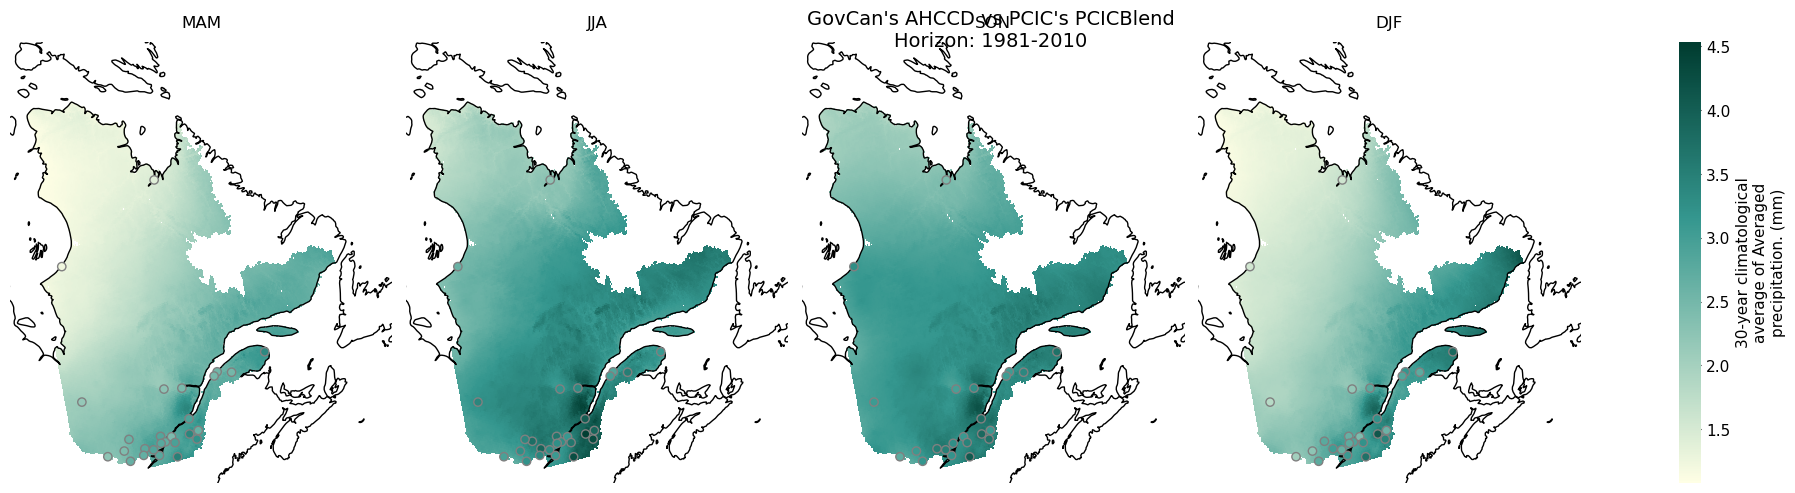

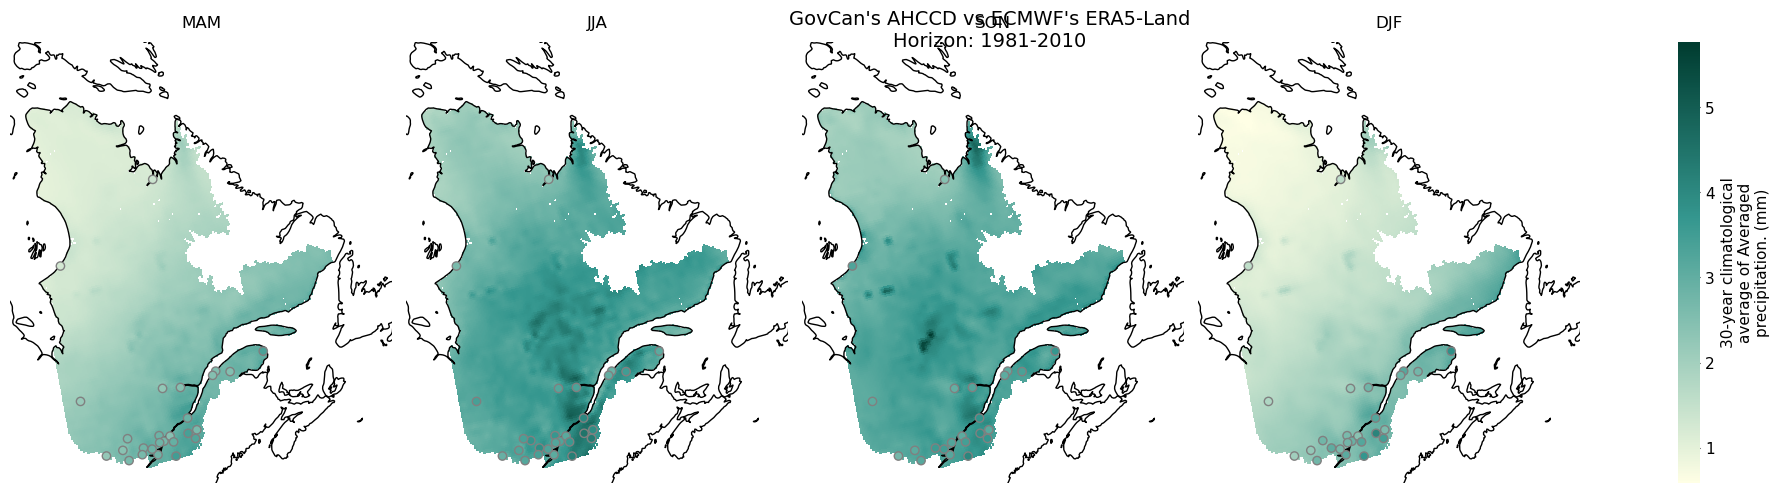

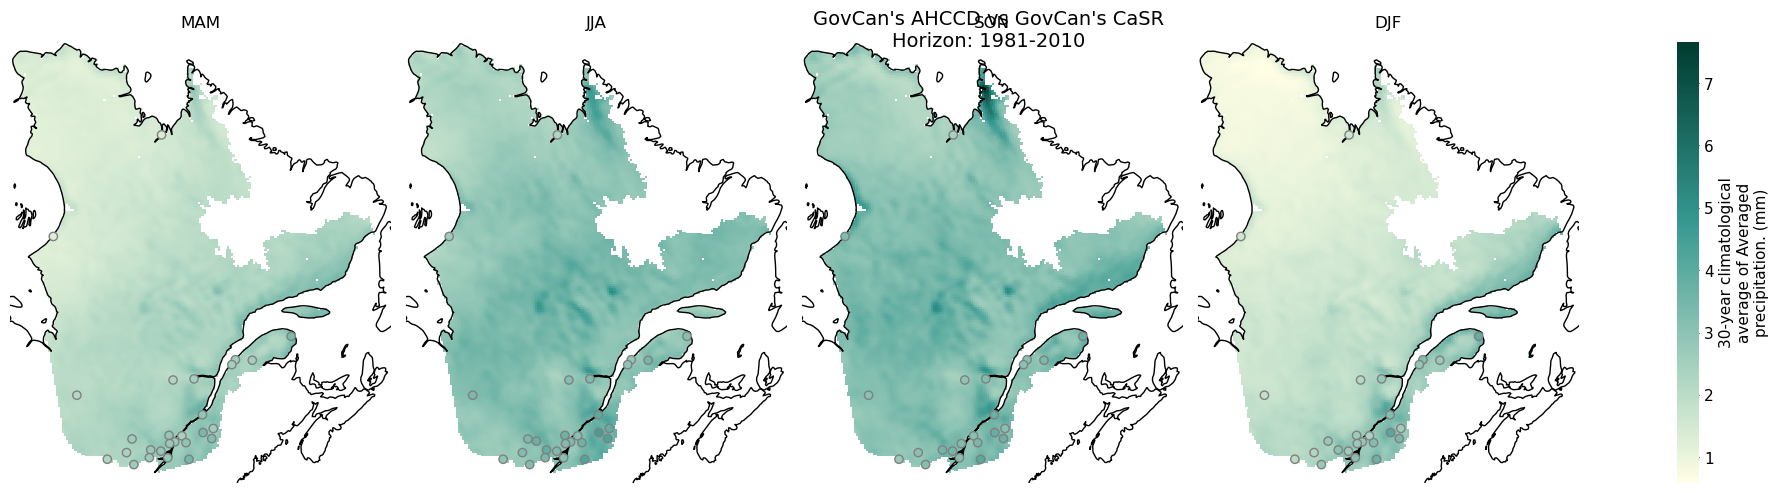

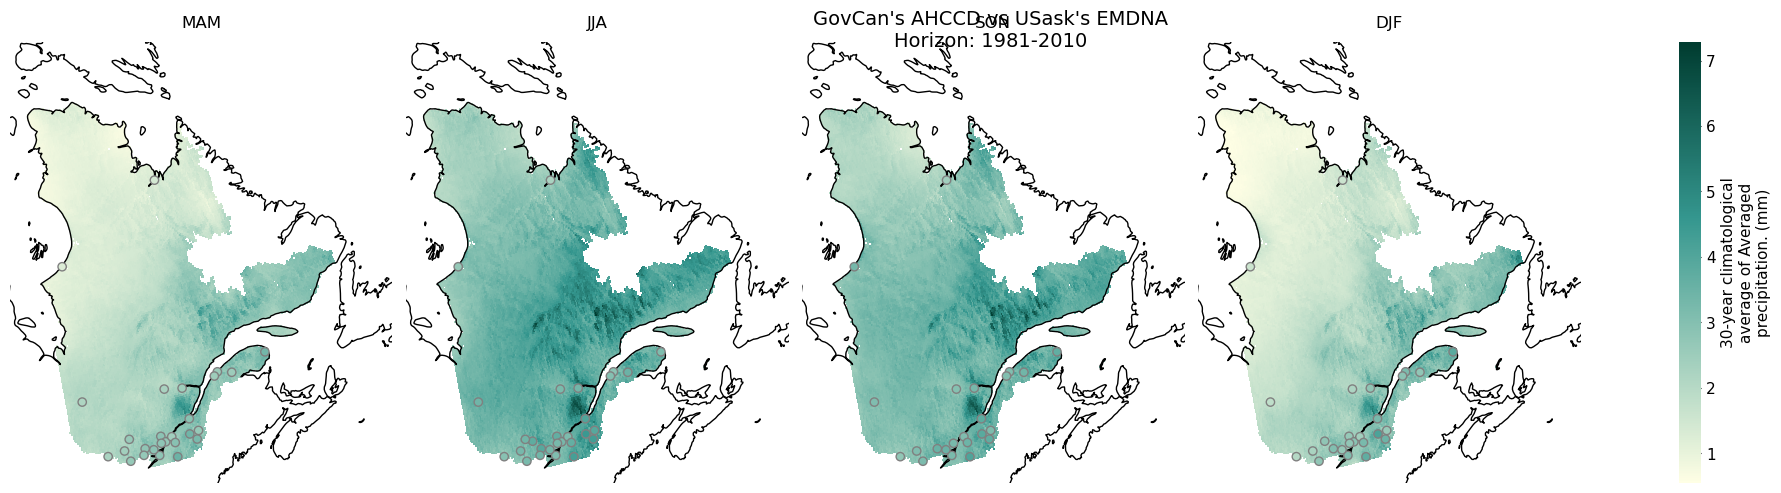

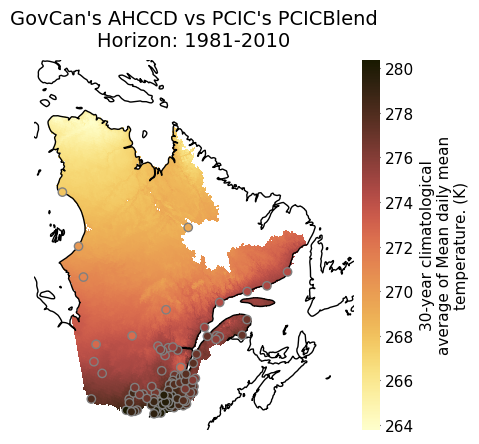

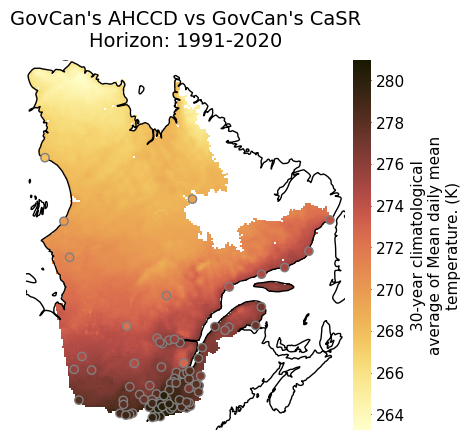

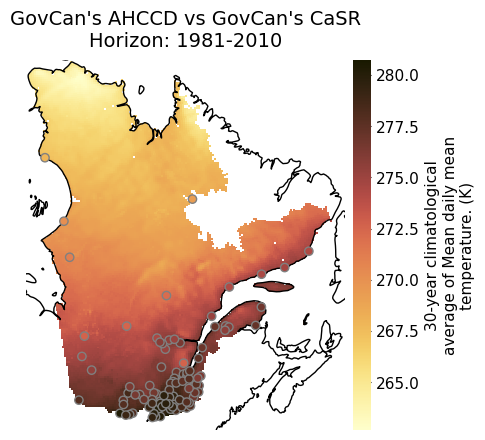

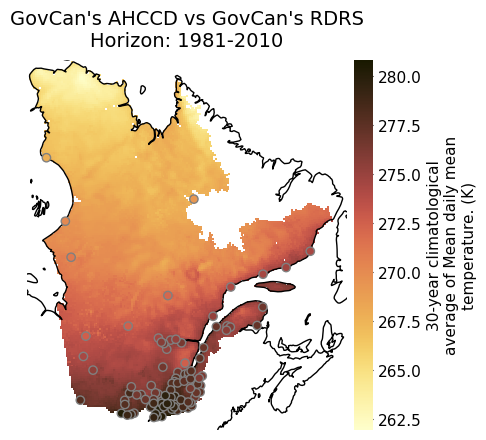

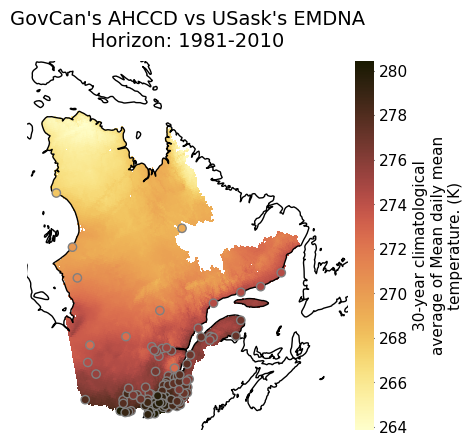

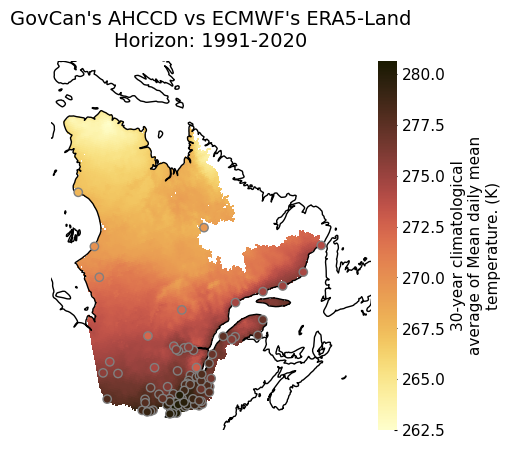

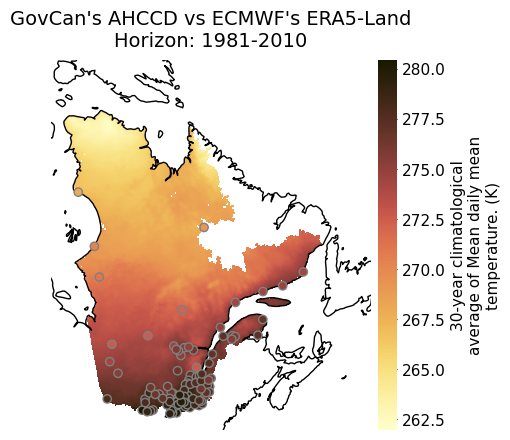

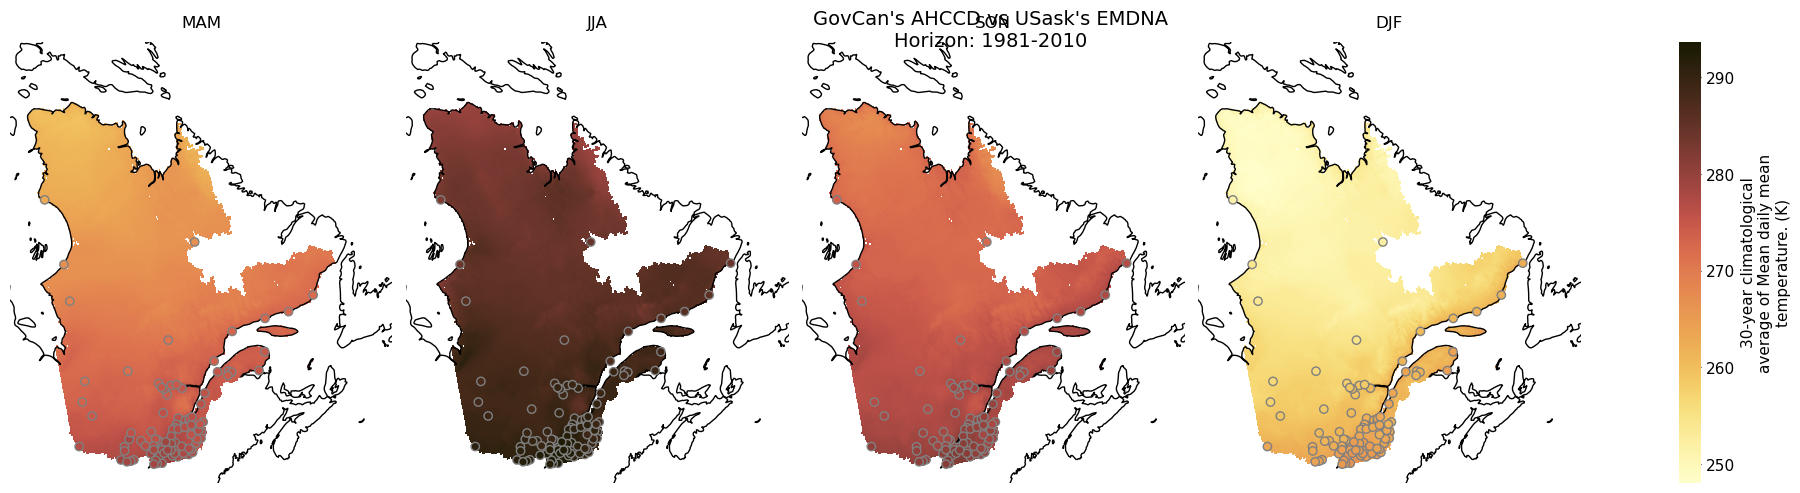

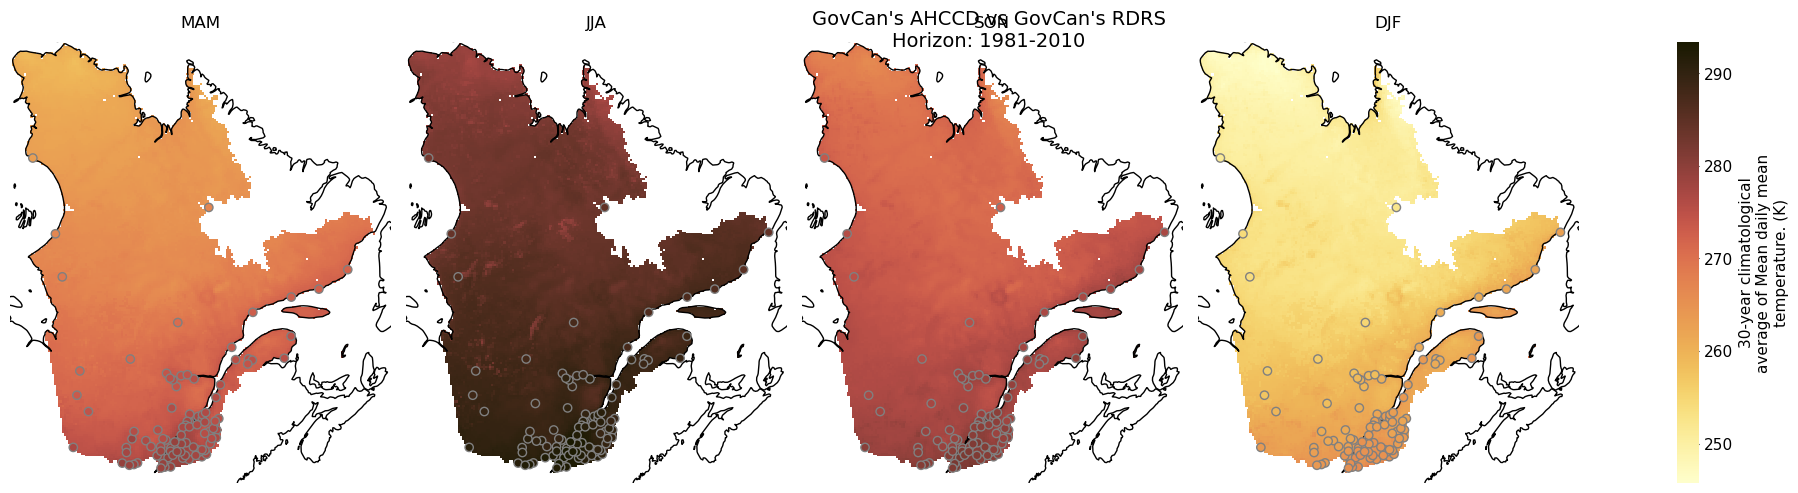

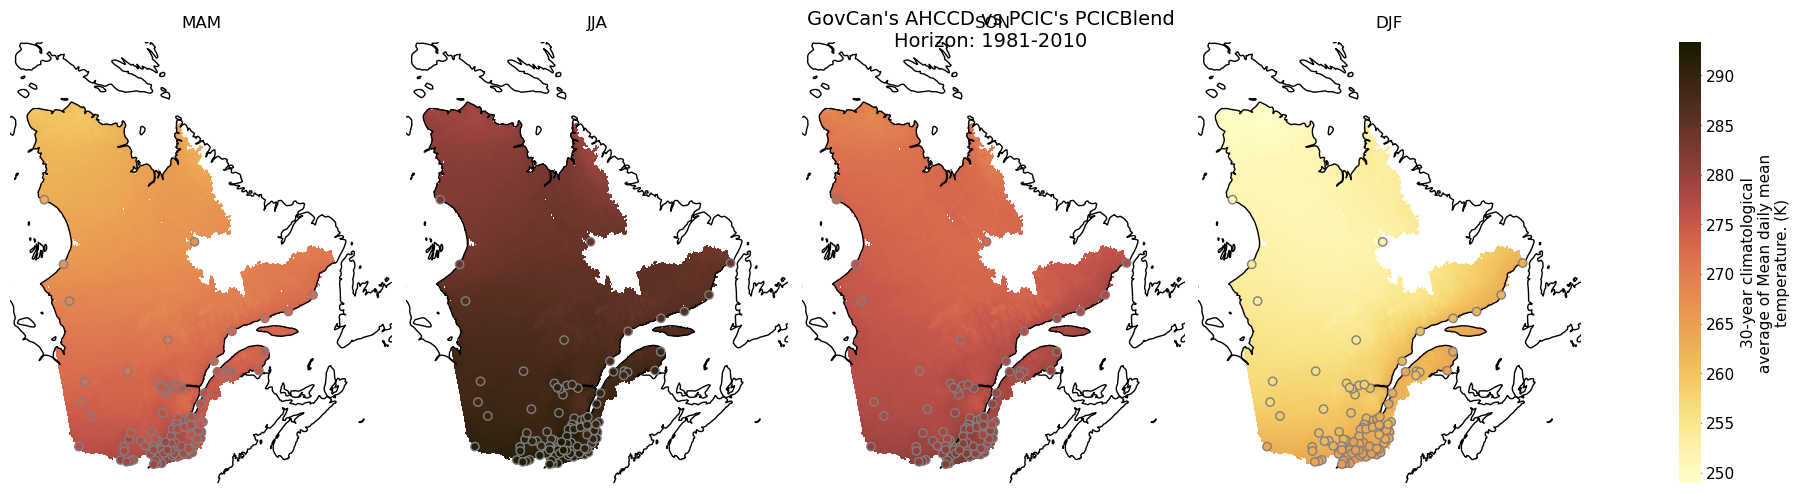

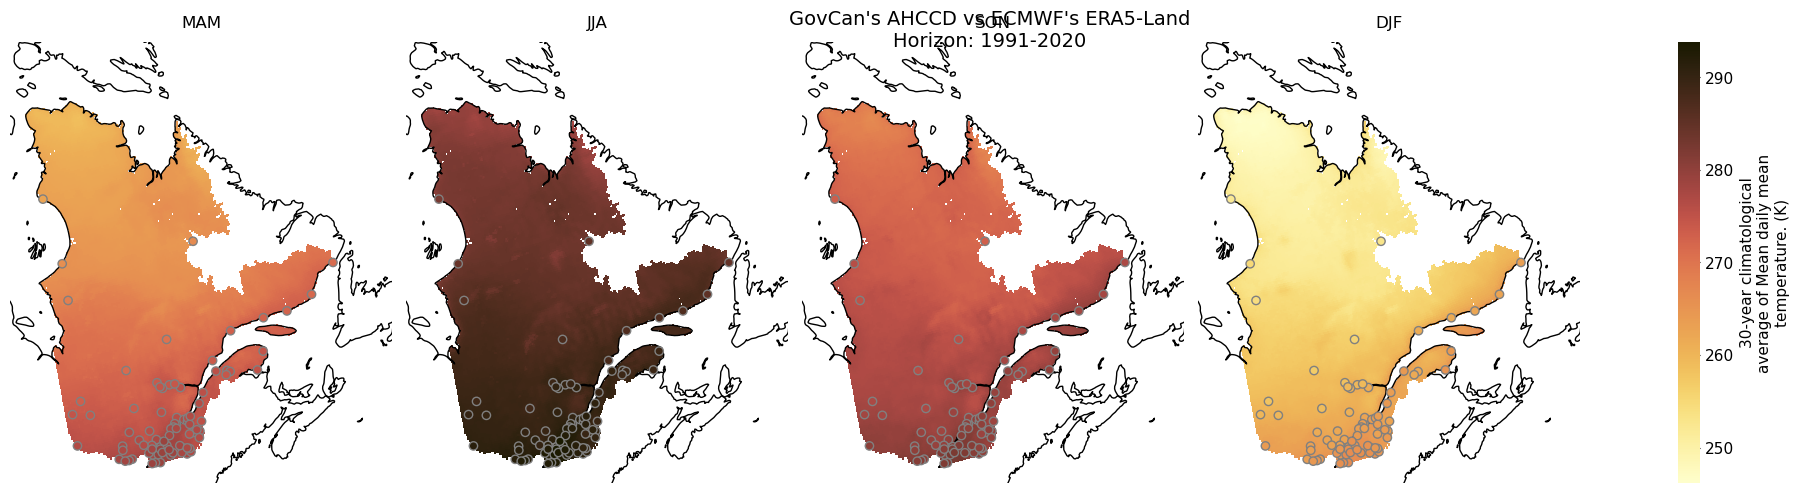

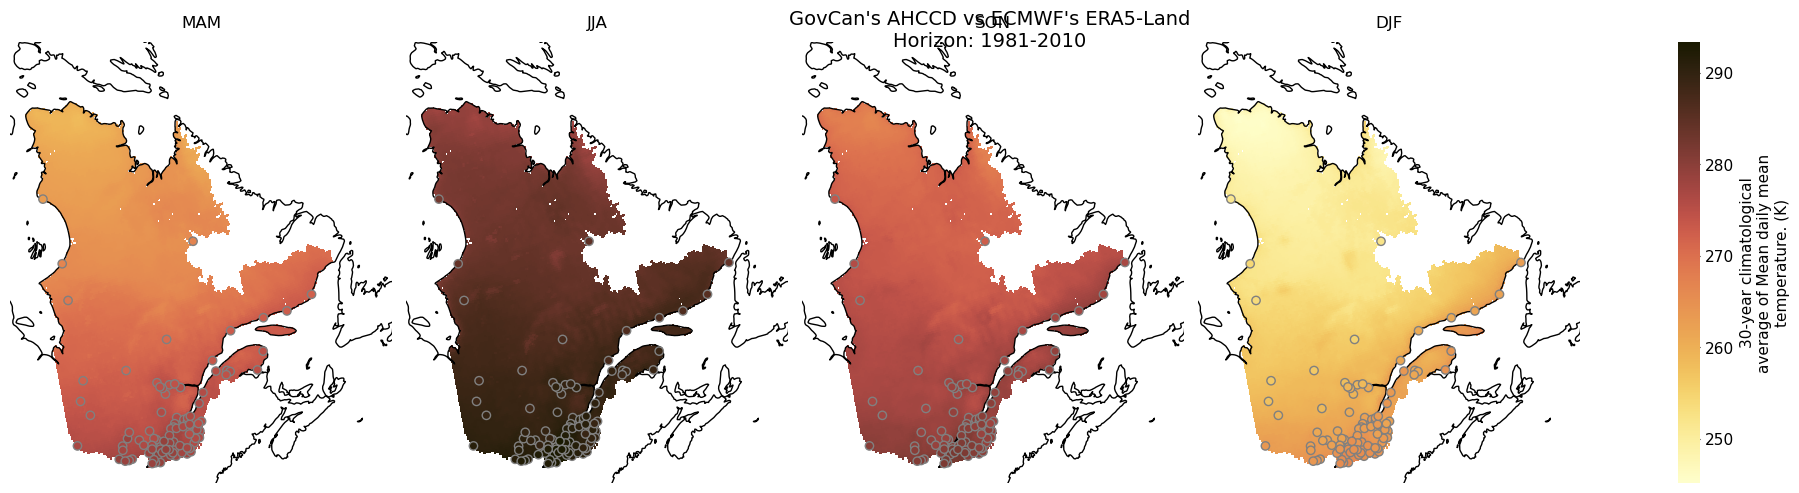

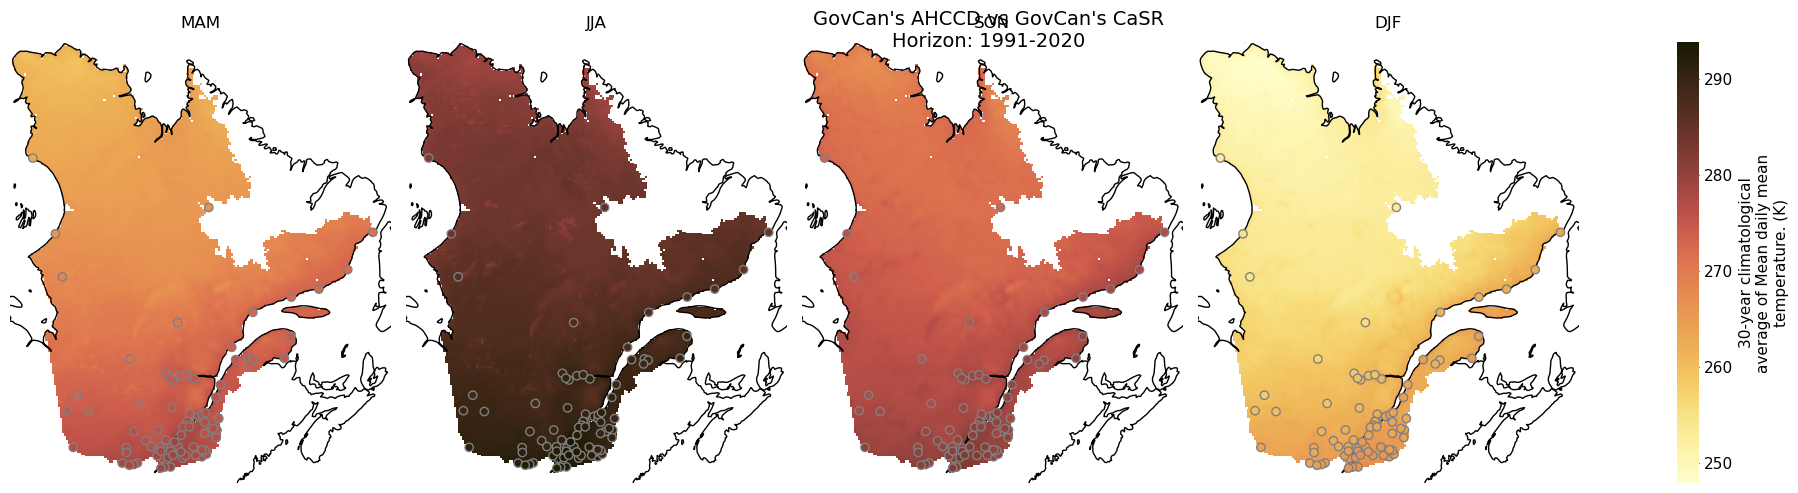

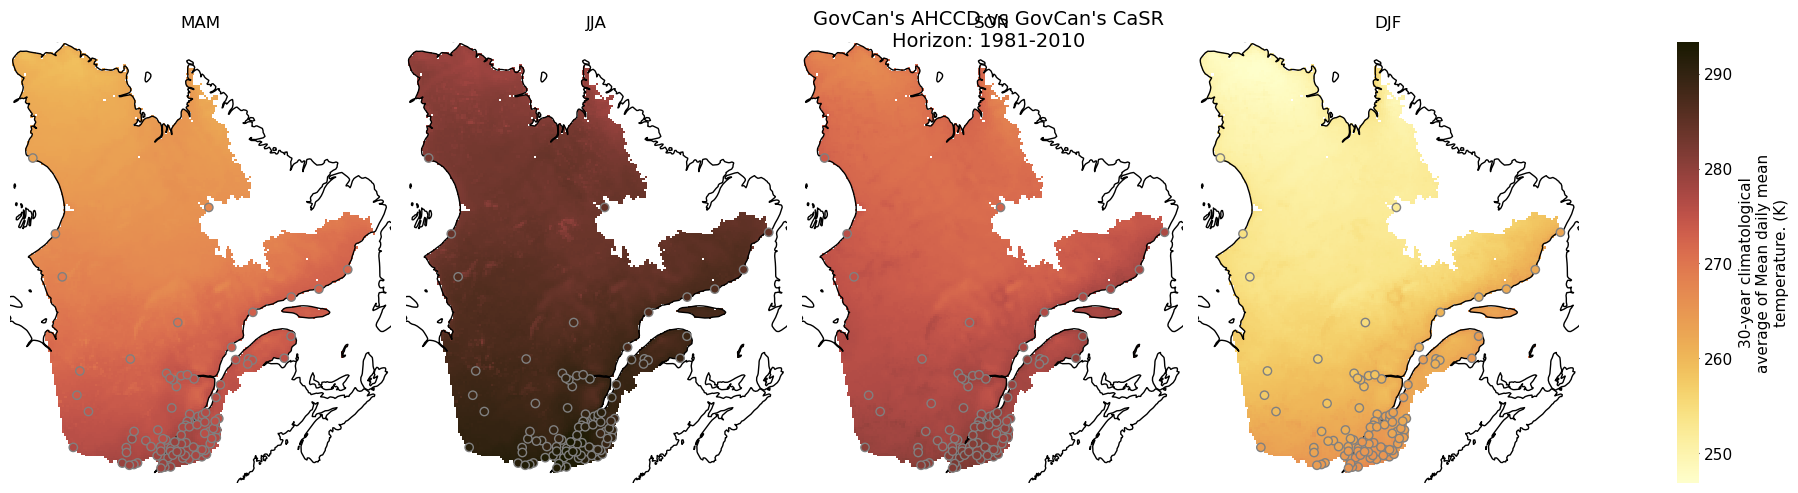

In [89]:
plot_climatology_maps()